# Introduction

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.insert(0, '..')
from src import plotFeatureImportance, plotTree, plotMatrix, plotReport

dataPath  = r"..\data\csv" + "\\"
plotPath = r"..\plots\introduction" + "\\"
tablePath = r"..\tables\introduction" + "\\"

In [2]:
def preProcess(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset = dataset.fillna("")
    
    companies = {'Apple, Inc.': 'Apple', 
                 'Tile, Inc.,Tile, Inc.': 'Tile', 
                 'Samsung Electronics Co., Ltd.,Samsung Electronics Co., Ltd.': 'Samsung'}

    dataset = dataset.replace(companies)

    dataset = pd.get_dummies(dataset, prefix='Company ID', prefix_sep=' ', columns=['Company ID'], drop_first=False, dtype=int)
    dataset = pd.get_dummies(dataset, prefix='UUID', prefix_sep=' ', columns=['UUID'], drop_first=False, dtype=int)
    dataset = dataset[['Label', 'Company ID Apple', 'UUID Samsung', 'UUID Tile']]

    dataset.reset_index(drop = True, inplace = True)
    
    return dataset

def filesToDataFrame(filesDict: dict[str:str], filePath: str = dataPath) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict:
        new_dataset = pd.read_csv(filePath + f, encoding = 'cp1252')
        
        new_dataset =  new_dataset[['Company ID', 'UUID']]
        new_dataset['Label'] = filesDict[f]
        
        dataset = pd.concat([dataset, new_dataset])

    dataset = preProcess(dataset)

    return dataset

In [3]:
files = {r"AirTag\AirTag_(lost).csv": 'AirTag',
         r"SmartTag\SmartTag_(lost).csv": 'SmartTag',
         r"Tile\Tile_(lost).csv": 'Tile'
        }
    
data = filesToDataFrame(files)

In [4]:
data.head()

,Label,Company ID Apple,UUID Samsung,UUID Tile
0,AirTag,1,0,0
1,AirTag,1,0,0
2,AirTag,1,0,0
3,AirTag,1,0,0
4,AirTag,1,0,0


In [5]:
from matplotlib.ticker import PercentFormatter

def plotDistribution(dataset: pd.DataFrame, title:str, savePath:str=None):
    temp = dataset.groupby("Label").sum().reset_index()
    sizes = dataset.groupby("Label").size().to_numpy()
    
    x = sorted(list(temp['Label']))
    y_prev = np.zeros((len(x)))

    fig = plt.figure(figsize=(16, 9), dpi = 100)
    
    for column in temp.columns[1:]:
        y = temp[column] / sizes * 100
        legend_label = str(column).split(" ")[-1]
        plt.bar(x, y, bottom=y_prev, label=legend_label)
        y_prev += y
        
    plt.legend(loc='upper right', fontsize = 12)
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.ylim(bottom=0, top=110)
    plt.ylabel("% of Packets", fontsize = 15)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    plt.tight_layout()
    
    if savePath is not None:
        fig.savefig(plotPath + title, dpi = 300)
    
    plt.show()

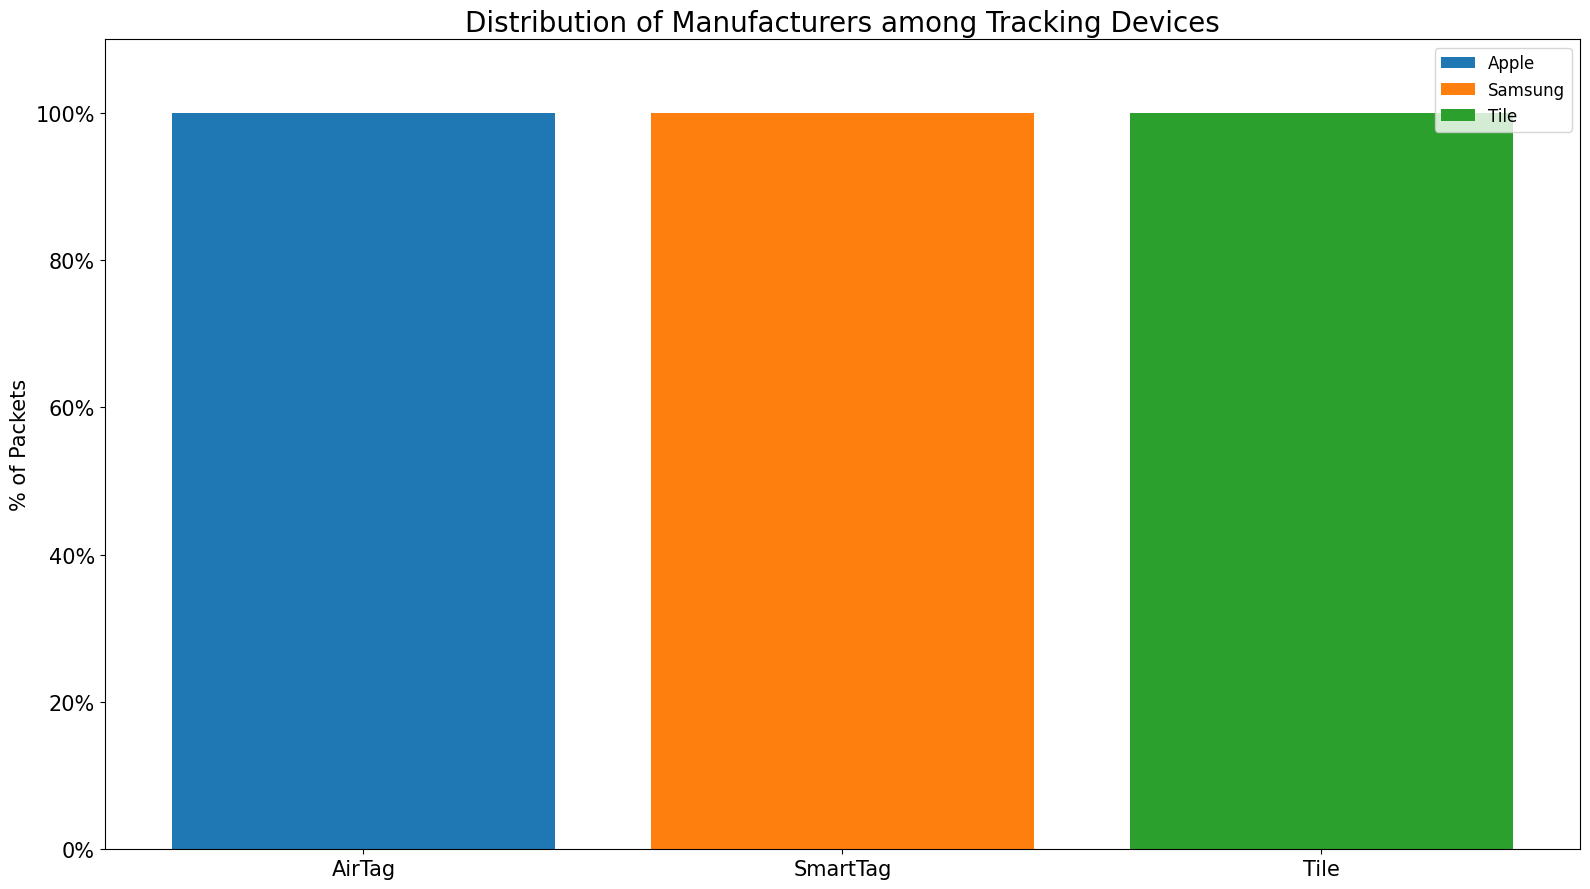

In [6]:
plotDistribution(data, title= 'Distribution of Manufacturers among Tracking Devices', savePath=plotPath)

In [7]:
from sklearn.model_selection import train_test_split

def splitData(dataset: pd.DataFrame):
    Y = dataset['Label']
    X = dataset.drop(['Label'], axis = 1)
    
    labels = sorted(list(Y.unique()))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1, stratify = Y, shuffle = True)
    
    return  X_train, X_test, y_train, y_test, labels

In [8]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(random_state = 1)

X_train, X_test, y_train, y_test, labels = splitData(data)

y_pred_DT = DecisionTree.fit(X_train, y_train).predict(X_test)
modelName = "Decision Tree (Introduction)"

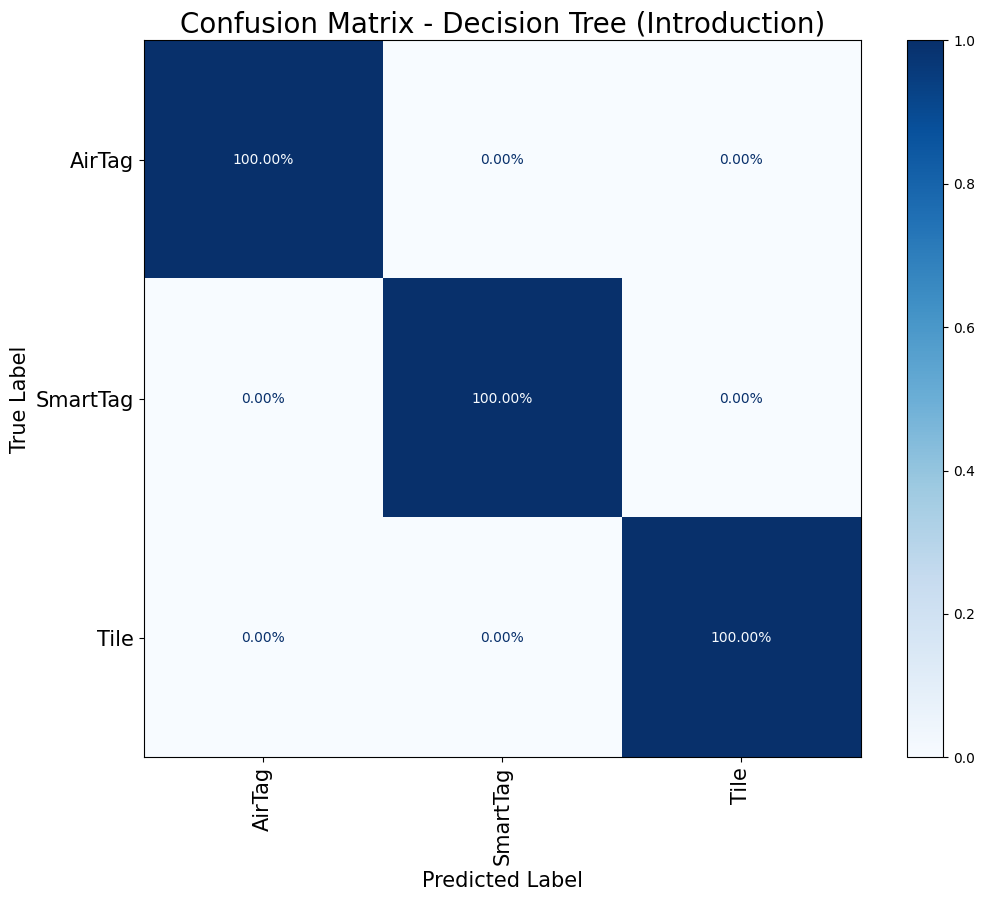

In [9]:
plotMatrix(y_test, y_pred_DT, labels, dpi = 100, name = modelName, savePath=plotPath)

In [10]:
plotReport(y_test, y_pred_DT, labels, savePath=tablePath, name=modelName)

Classification Report - Decision Tree (Introduction)
              precision    recall  f1-score   support

      AirTag     1.0000    1.0000    1.0000     16161
    SmartTag     1.0000    1.0000    1.0000      8207
        Tile     1.0000    1.0000    1.0000      8297

    accuracy                         1.0000     32665
   macro avg     1.0000    1.0000    1.0000     32665
weighted avg     1.0000    1.0000    1.0000     32665


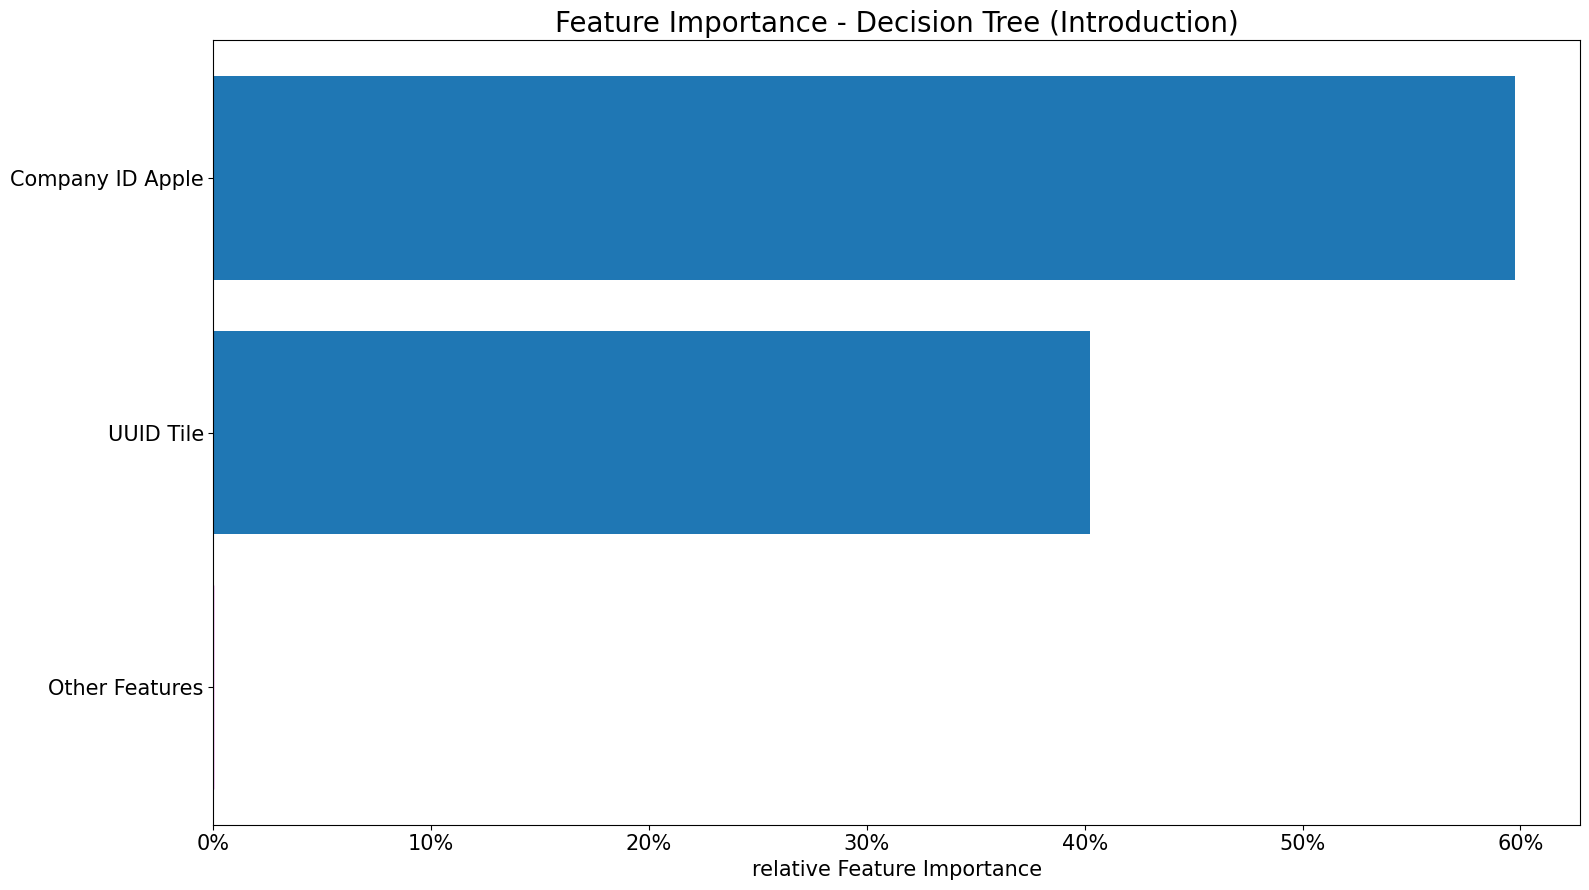

In [11]:
plotFeatureImportance(data.columns[1:], DecisionTree.feature_importances_, dpi = 100, name = modelName, savePath = plotPath)

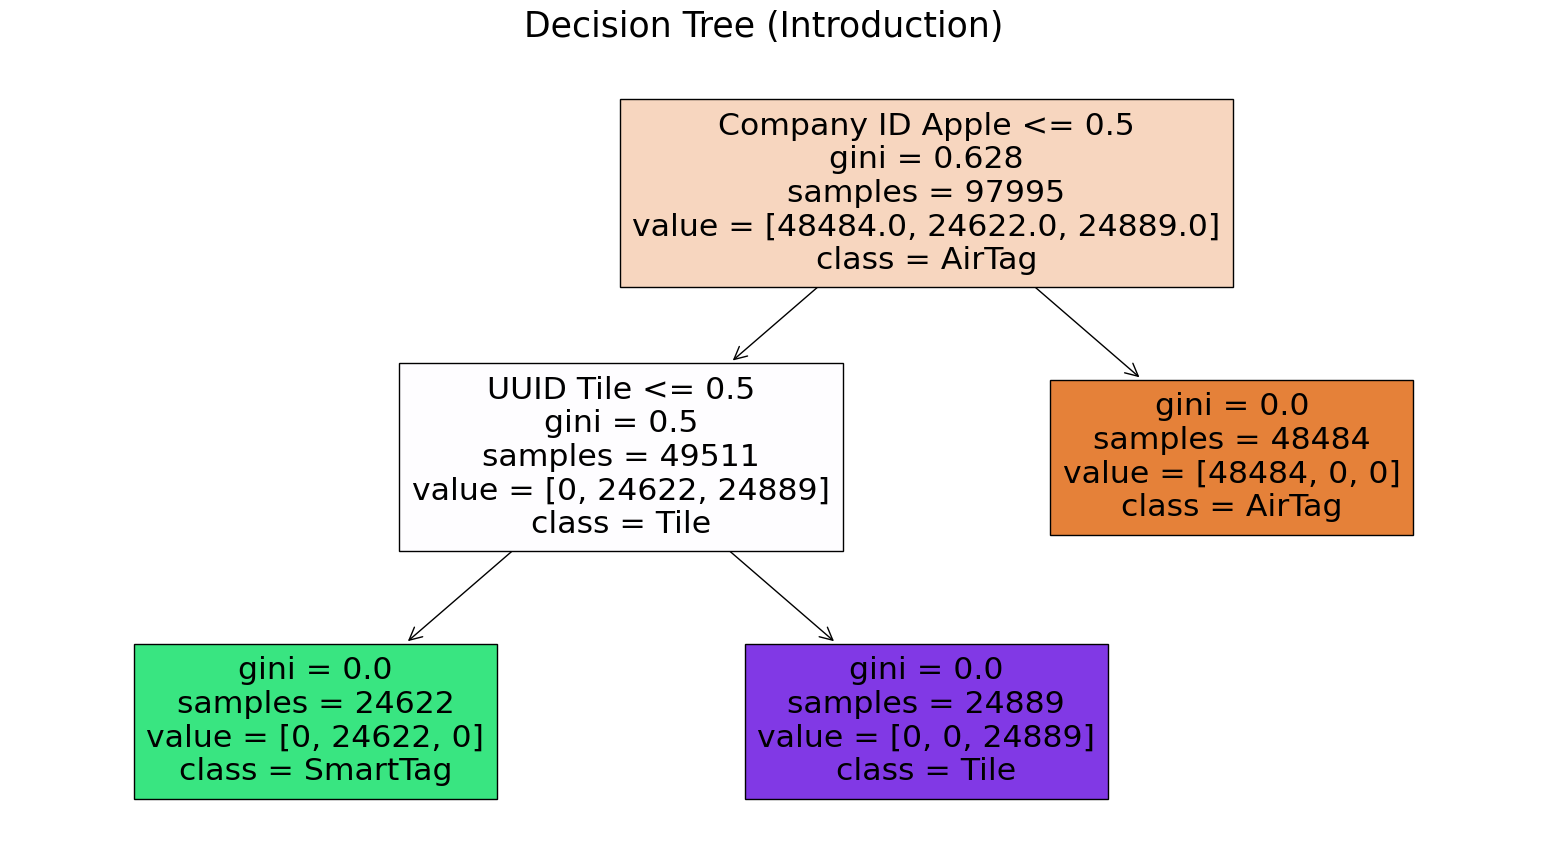

In [12]:
plotTree(DecisionTree, name = "Decision Tree (Introduction)", features_names= data.columns[1:], savePath=plotPath, sizeFactor=1)

In [13]:
def predictLabel(row):
    if bool(row['Company ID Apple']):
        return 'AirTag'
    elif bool(row['UUID Tile']):
        return 'Tile'
    else:
        return 'SmartTag'

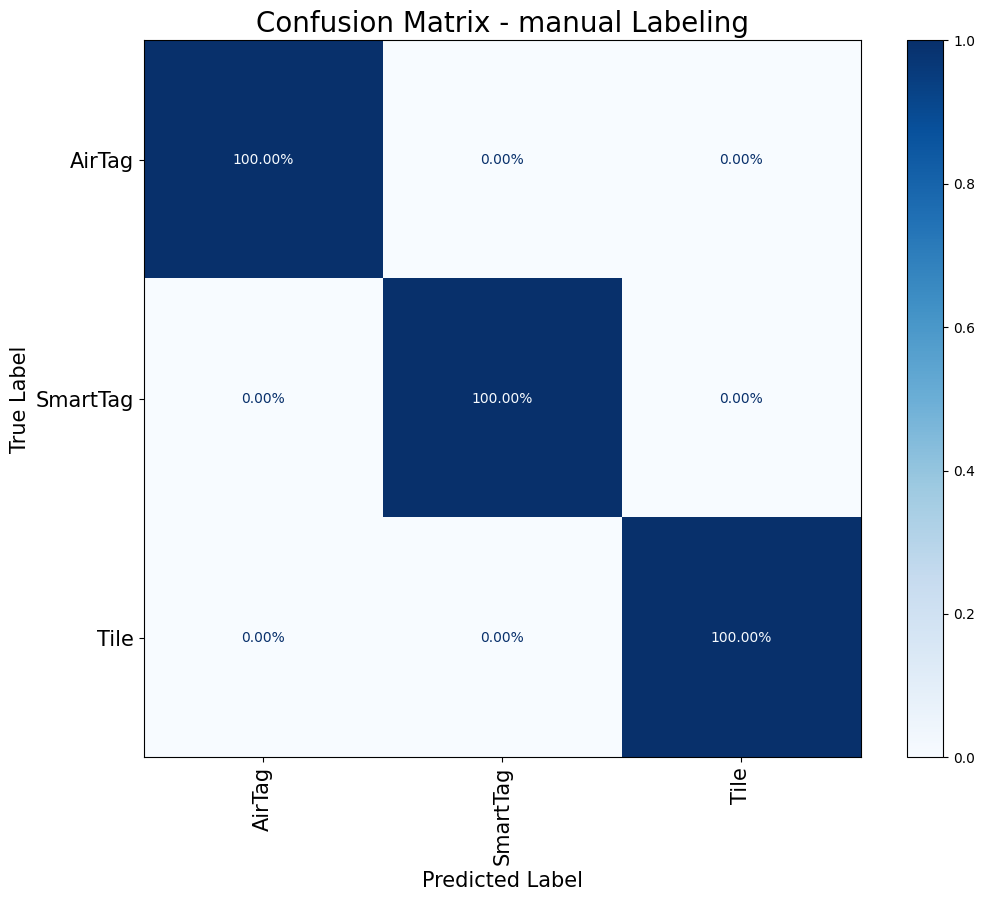

In [14]:
y_pred_manual = X_test.apply(predictLabel, axis=1)

plotMatrix(y_test, y_pred_manual, labels, dpi = 100, name = "manual Labeling", savePath=plotPath)

In [15]:
files = {r"AirTag\AirTag_(lost).csv": 'AirTag',
         r"SmartTag\SmartTag_(lost).csv": 'SmartTag',
         r"Tile\Tile_(lost).csv": 'Tile',
         r"iPhone\iPhone_(offline).csv": 'iPhone',
         }

data = filesToDataFrame(files)

In [16]:
X_train, X_test, y_train, y_test, labels = splitData(data)

y_pred_DT = DecisionTree.fit(X_train, y_train).predict(X_test)
modelName = "mixed Classes"

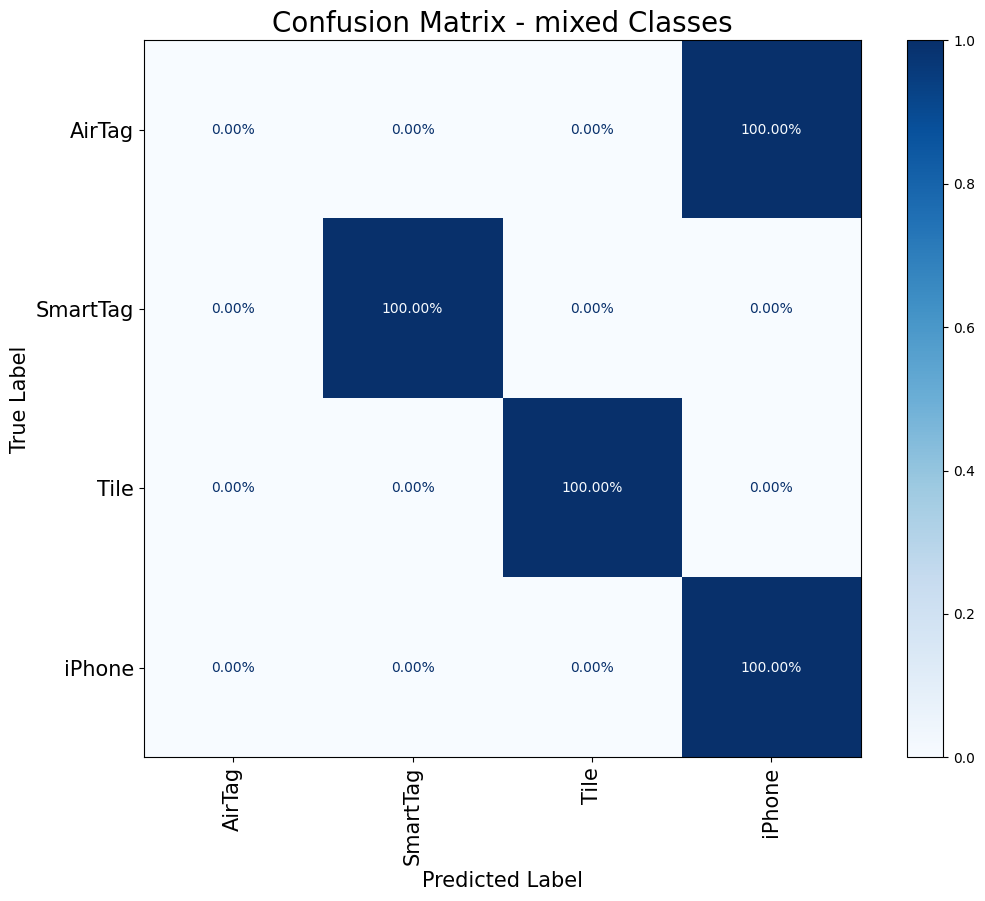

In [17]:
plotMatrix(y_test, y_pred_DT, labels, dpi = 100, name = modelName, savePath=plotPath)

In [18]:
plotReport(y_test, y_pred_DT, labels, name = modelName, savePath=tablePath)

Classification Report - mixed Classes
              precision    recall  f1-score   support

      AirTag     0.0000    0.0000    0.0000     16161
    SmartTag     1.0000    1.0000    1.0000      8207
        Tile     1.0000    1.0000    1.0000      8297
      iPhone     0.9024    1.0000    0.9487    149481

    accuracy                         0.9113    182146
   macro avg     0.7256    0.7500    0.7372    182146
weighted avg     0.8312    0.9113    0.8692    182146


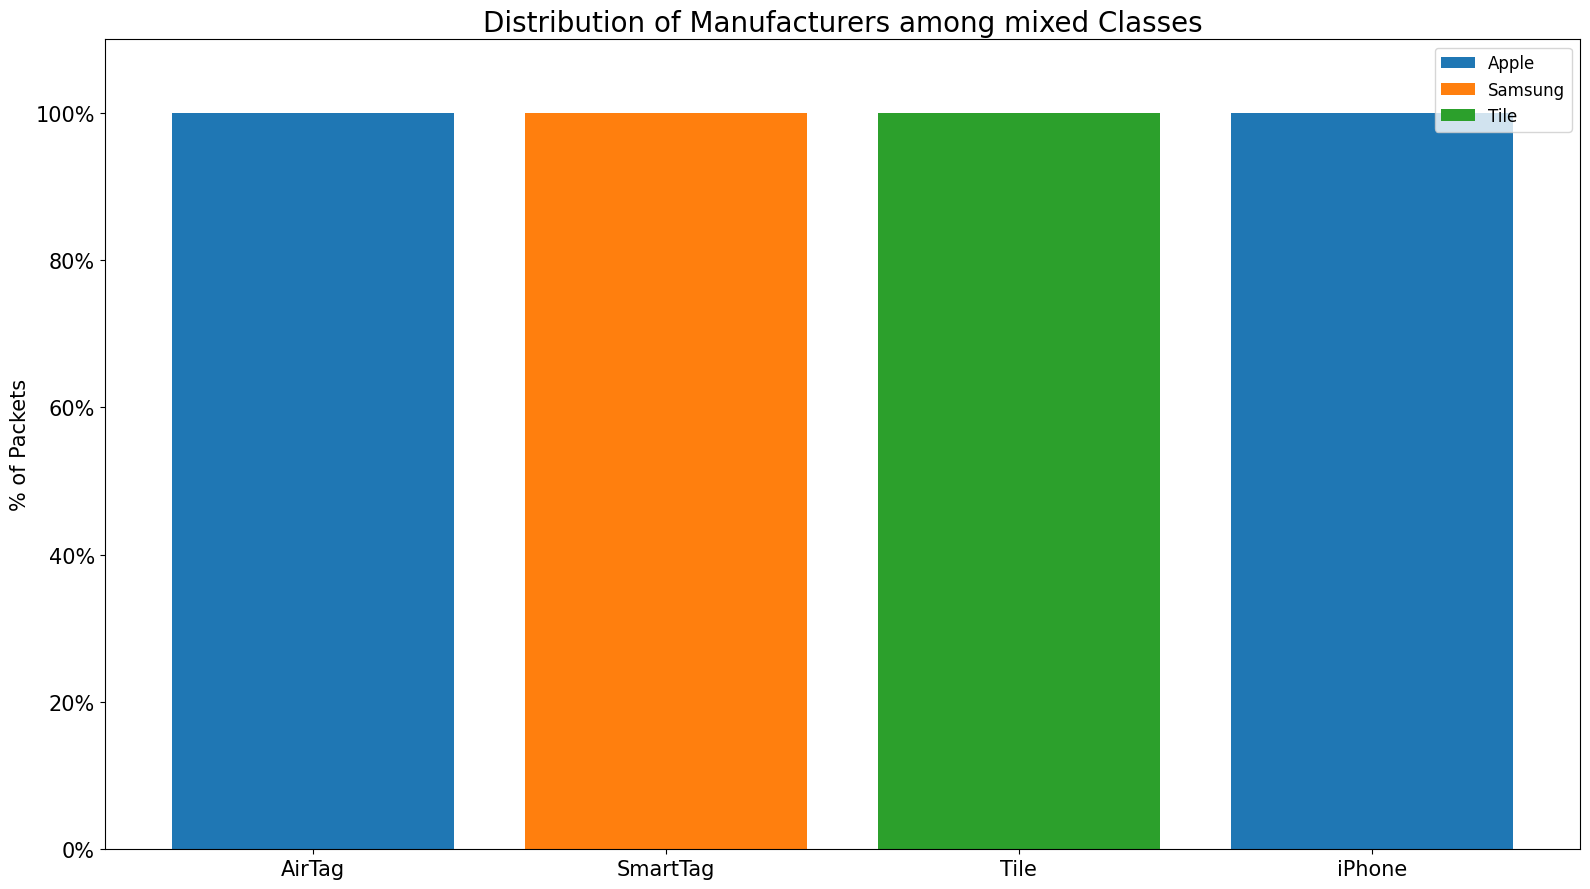

In [19]:
plotDistribution(data, title= 'Distribution of Manufacturers among mixed Classes', savePath=plotPath)